In [1]:
import time
import torch

from torch import nn, Tensor
from torch.utils.data import DataLoader

# flow_matching
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import Solver, ODESolver
from flow_matching.utils import ModelWrapper

# visualization
import matplotlib.pyplot as plt

from matplotlib import cm


# To avoide meshgrid warning
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='torch')


In [2]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')
torch.manual_seed(42)

Using cpu.


In [3]:
class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor:
        return torch.sigmoid(x) * x


# TODO: need to resolve temporal locality problem maybe with a CNN later.
class MLP(nn.Module):
    def __init__(self, input_dim: int, time_dim: int = 1, hidden_dim: int = 128):
        super().__init__()

        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim

        self.main = nn.Sequential(
            nn.Linear(input_dim + time_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        sz = x.size()
        x = x.reshape(-1, self.input_dim)
        t = t.reshape(-1, self.time_dim).float()

        t = t.reshape(-1, 1).expand(x.shape[0], 1)
        h = torch.cat([x, t], dim=1)
        output = self.main(h)

        return output.reshape(*sz)

In [4]:
def collate_fn(batch):
    observations = [torch.as_tensor(x.observations) for x in batch]
    actions = [torch.as_tensor(x.actions) for x in batch]
    rewards = [torch.as_tensor(x.rewards) for x in batch]
    terminations = [torch.as_tensor(x.terminations) for x in batch]
    truncations = [torch.as_tensor(x.truncations) for x in batch]
    episode_lengths = torch.tensor([len(x.actions) for x in batch], dtype=torch.long)

    return {
        "id": torch.Tensor([x.id for x in batch]),
        "observations": torch.nn.utils.rnn.pad_sequence(
            observations,
            batch_first=True
        ),
        "actions": torch.nn.utils.rnn.pad_sequence(
            actions,
            batch_first=True
        ),
        "rewards": torch.nn.utils.rnn.pad_sequence(
            rewards,
            batch_first=True
        ),
        "terminations": torch.nn.utils.rnn.pad_sequence(
            terminations,
            batch_first=True
        ),
        "truncations": torch.nn.utils.rnn.pad_sequence(
            truncations,
            batch_first=True
        ),
        "episode_lengths": episode_lengths
    }

In [5]:
def create_trajectory_chunks(batch, horizon):
    """
    Processes a padded batch to create fixed-size trajectory chunks.
    """
    batch_size = batch['observations'].shape[0]
    all_chunks = []

    for i in range(batch_size):
        # Get the data for one episode and its true length
        obs = batch['observations'][i]      # Shape: (max_len, 8)
        act = batch['actions'][i]          # Shape: (max_len-1, 2)
        length = batch['episode_lengths'][i]       # Scalar, e.g., 495

        # A single episode can produce multiple chunks
        # We slide a window of size 'horizon' over the valid part of the episode
        for start_idx in range(length - horizon + 1):
            end_idx = start_idx + horizon

            # Slice the observation and action sequences to get a chunk
            obs_chunk = obs[start_idx:end_idx] # Shape: (horizon, 8)
            act_chunk = act[start_idx:end_idx] # Shape: (horizon, 2)
            
            # Combine them into a single (horizon, 10) tensor
            chunk = torch.cat([obs_chunk, act_chunk], dim=-1)

            # Flatten the chunk to the final 1000-D vector and add to our list
            all_chunks.append(chunk.flatten())

    if not all_chunks:
        return None

    return torch.stack(all_chunks)

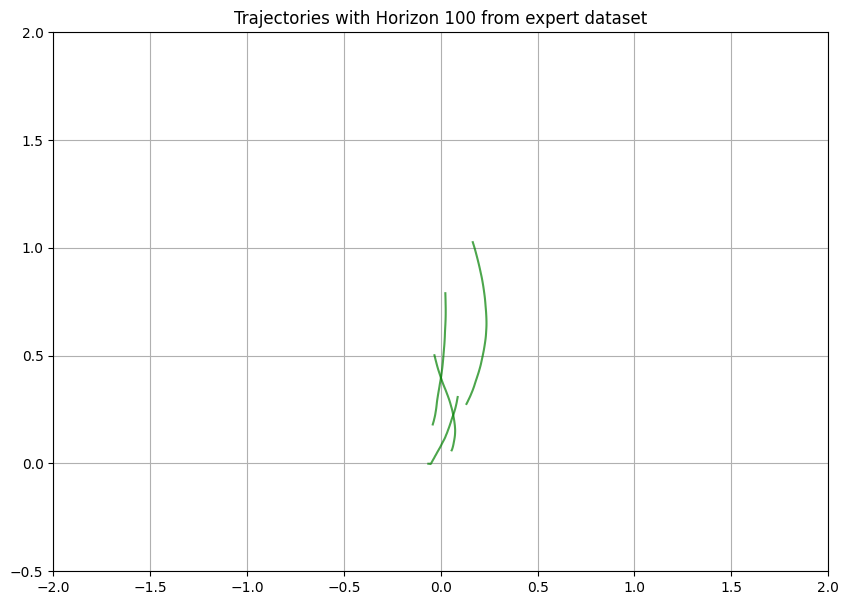

In [6]:
# load minari dataset
import minari
import random
horizon = 100
obs_dim = 8
action_dim = 2

def visualize_chunk(ax, chunk, color):
    assert chunk.shape == (horizon * (obs_dim + action_dim),)
    chunk = chunk.reshape(horizon, obs_dim + action_dim)
    expert_obs = chunk[:, :obs_dim]
    x = expert_obs[:, 0].cpu().numpy()
    y = expert_obs[:, 1].cpu().numpy()
    ax.plot(x, y, linestyle='-', color=color, alpha=0.7)
    ax.set_xlim(-2, 2)
    ax.set_ylim(-0.5, 2)
    ax.grid(True)

minari_dataset = minari.load_dataset(dataset_id="LunarLanderContinuous-v3/ppo-1000-deterministic-v1")
dataloader = DataLoader(minari_dataset, batch_size=256, shuffle=True, collate_fn=collate_fn)
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title(f'Trajectories with Horizon {horizon} from expert dataset')
for batch in dataloader:
    processed_chunks = create_trajectory_chunks(batch, 100)
    random_chunk = random.choice(processed_chunks)
    visualize_chunk(ax, random_chunk, color="green")



In [ ]:
from src.utils.loggers import WandBLogger
env = minari_dataset.recover_environment()
horizon = 100
action_dim = env.action_space.shape[0]
obs_dim = env.observation_space.shape[0]
input_dim = (obs_dim + action_dim) * horizon

# Training params
lr = 0.0001
num_epochs = 100
print_every = 10
hidden_dim = 256

config = {
    "horizon": horizon,
    "action_dim": action_dim,
    "obs_dim": obs_dim,
    "input_dim": input_dim,
    "hidden_dim": hidden_dim,
    "num_epochs": num_epochs,
    "lr": lr
}

logger = WandBLogger(config = config)
vf = MLP(input_dim=input_dim, time_dim=1, hidden_dim=hidden_dim).to(device)
path = AffineProbPath(scheduler=CondOTScheduler())
optim = torch.optim.Adam(vf.parameters(), lr=lr)

print("Starting training...")
for epoch in range(num_epochs):
    total_epoch_loss = 0.0
    total_chunks = 0
    start_time = time.time()

    for batch in dataloader:
        optim.zero_grad()

        x_1 = create_trajectory_chunks(batch, horizon)
        if x_1 is None:
            continue
        x_1 = x_1.to(device)
        x_0 = torch.randn_like(x_1).to(device)
        t = torch.rand(x_1.shape[0]).to(device)

        # 3. Forward pass and Loss
        path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
        predicted_velocity = vf(path_sample.x_t, path_sample.t)
        loss = torch.pow(predicted_velocity - path_sample.dx_t, 2).mean()

        # 4. Backward pass and Optimize
        loss.backward()
        optim.step()
        total_epoch_loss += loss.item()
        total_chunks += 1

    avg_epoch_loss = total_epoch_loss / total_chunks if total_chunks > 0 else 0
    logger.log({"avg_epoch_loss": avg_epoch_loss})
    if (epoch + 1) % print_every == 0:
        elapsed = time.time() - start_time
        print(f"| Epoch {epoch+1:6d} | {elapsed:.2f} s/epoch | Loss {avg_epoch_loss:8.5f} ")
        start_time = time.time()
print("Training finished.")

wandb: Currently logged in as: tsufanglu (frankcholula) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Starting training...
| Epoch     10 | 4.81 s/epoch | Loss  1.07045 
| Epoch     20 | 4.88 s/epoch | Loss  1.04827 
| Epoch     30 | 4.86 s/epoch | Loss  1.03940 
| Epoch     40 | 4.80 s/epoch | Loss  1.03383 
| Epoch     50 | 4.56 s/epoch | Loss  1.03073 
| Epoch     60 | 4.54 s/epoch | Loss  1.02807 
| Epoch     70 | 4.53 s/epoch | Loss  1.02523 
| Epoch     80 | 4.45 s/epoch | Loss  1.02215 
| Epoch     90 | 4.54 s/epoch | Loss  1.01701 
| Epoch    100 | 4.55 s/epoch | Loss  1.01001 
Training finished.


In [8]:
# try sampling from trained model...
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t)

wrapped_vf = WrappedModel(vf)
step_size = 0.05
batch_size = 1  # batch size
T = torch.linspace(0,1,10)  # sample times
T = T.to(device=device)

x_init = torch.randn((batch_size, input_dim), dtype=torch.float32, device=device)
solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class
sol = solver.sample(time_grid=T, x_init=x_init, method='midpoint', step_size=step_size, return_intermediates=True)
final_trajectory = sol[-1].reshape(horizon, obs_dim + action_dim)
observations = final_trajectory[:, :obs_dim]
actions = final_trajectory[:, obs_dim:obs_dim + action_dim]
assert(observations.shape == (horizon, obs_dim))
assert(actions.shape == (horizon, action_dim))

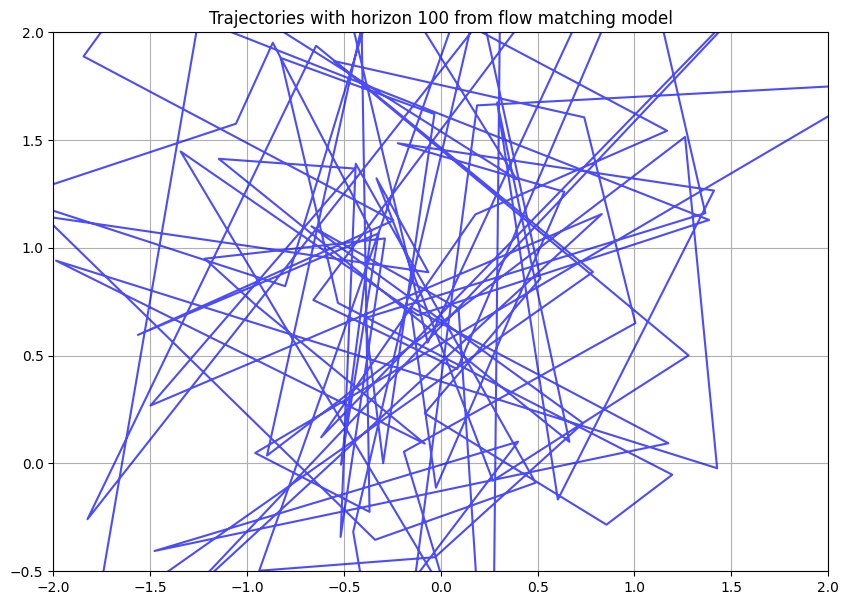

In [16]:
fig, ax = plt.subplots(figsize=(10, 7))
x_init = torch.randn((batch_size, input_dim), dtype=torch.float32, device=device)
sol = solver.sample(time_grid=T, x_init=x_init, method='midpoint', step_size=step_size, return_intermediates=True)
final_trajectory_chunk = sol[-1].squeeze(0).detach()
ax.set_title(f'Trajectories with horizon {horizon} from flow matching model')
visualize_chunk(ax, final_trajectory_chunk, color="blue")

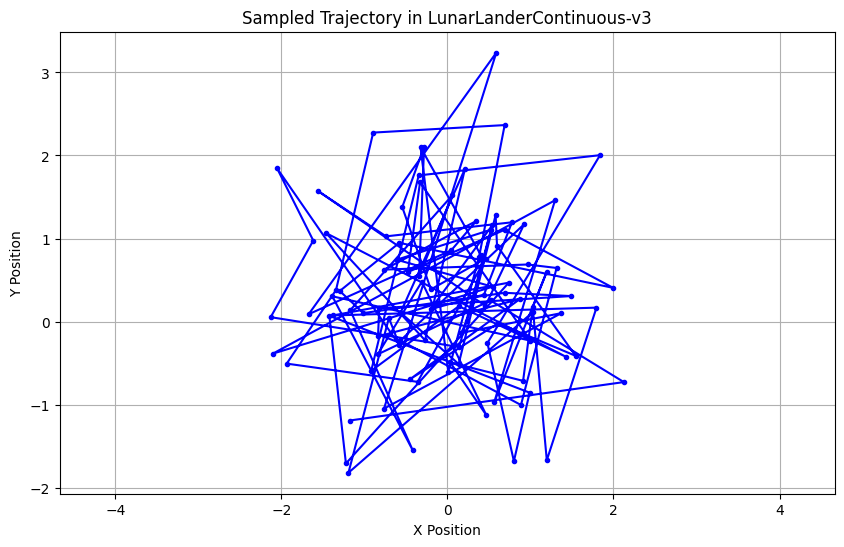

In [18]:
# The state is: [x, y, vx, vy, angle, angular_v, leg1_contact, leg2_contact]
x = observations[:, 0].cpu().numpy()
y = observations[:, 1].cpu().numpy()

# plot out x and y positions
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-', color='b', markersize=3)
plt.title('Sampled Trajectory in LunarLanderContinuous-v3')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid()
plt.axis('equal')
plt.show()

In [ ]:
# load minari dataset
import minari
minari_dataset = minari.load_dataset(dataset_id="LunarLanderContinuous-v3/ppo-1000-deterministic-v1")
dataloader = DataLoader(minari_dataset, batch_size=256, shuffle=True, collate_fn=collate_fn)
for batch in dataloader:
    processed_chunks = create_trajectory_chunks(batch, 100)
    print(processed_chunks.shape)


torch.Size([48515, 1000])
torch.Size([47538, 1000])
torch.Size([47346, 1000])
torch.Size([42836, 1000])


In [32]:
def generate_trajectory():
    x_init = torch.randn((batch_size, input_dim), dtype=torch.float32, device=device)
    sol = solver.sample(time_grid=T, x_init=x_init, method='midpoint', step_size=step_size, return_intermediates=True)
    final_trajectory = sol[-1].reshape(horizon, obs_dim + action_dim)
    observations = final_trajectory[:, :obs_dim]
    actions = final_trajectory[:, obs_dim:obs_dim + action_dim]
    return observations, actions

In [36]:
observations, actions = generate_trajectory()
actions

tensor([[ 0.6933,  1.2620],
        [ 0.9141, -0.7578],
        [-0.2778, -0.0297],
        [-1.1006, -0.1082],
        [ 1.5951, -0.6175],
        [-0.3836, -0.0446],
        [-0.1757,  0.5843],
        [ 1.4135, -0.1827],
        [-0.1551,  1.8617],
        [ 0.0172,  0.8330],
        [ 1.4468,  2.7884],
        [ 0.7497, -1.6101],
        [ 0.5681, -0.0907],
        [-1.7759, -0.3689],
        [-0.8625,  0.1233],
        [ 0.6750,  0.8452],
        [ 0.3091, -0.3766],
        [-0.1376, -0.8588],
        [ 2.4244,  2.0277],
        [ 1.9761, -0.2045],
        [-1.8581, -1.6033],
        [ 0.3092,  0.4911],
        [ 0.0221,  0.3539],
        [ 1.3451,  1.8763],
        [ 0.7679, -0.8109],
        [ 0.6735,  0.1942],
        [-0.0487,  0.4205],
        [-0.0475,  0.8027],
        [ 0.1145,  0.9810],
        [ 0.4210,  1.1642],
        [ 0.0334,  1.1799],
        [-1.3239,  0.7651],
        [ 1.4809,  1.5239],
        [-0.2695,  0.0836],
        [ 2.5331, -0.6782],
        [ 0.3034,  2

In [28]:
horizon = 100
num_eval_episodes = 100
env = minari_dataset.recover_environment(eval_env = True)
model_rewards = []
random_rewards = []
for eps in range(num_eval_episodes):
    obs, _ = env.reset()
    total_rew = 0
    obs, actions = generate_trajectory()
    for i in range(horizon):
        action = actions[i].cpu().numpy()
        obs, rew, terminated, truncated, info = env.step(action)
        total_rew += rew
        if terminated or truncated:
            break
    model_rewards.append(total_rew)

    env.reset()
    total_rew_random = 0
    for i in range(horizon):
        action = env.action_space.sample()
        obs, rew, terminated, truncated, info = env.step(action)
        total_rew_random += rew
        if terminated or truncated:
            break
    random_rewards.append(total_rew_random)
    if (eps + 1) % 10 == 0:
        print(f"Finished episode {eps + 1}/{num_eval_episodes} - Model Reward: {total_rew}, Random Reward: {total_rew_random}")
env.close()
print("Evaluation finished.")


Finished episode 10/100 - Model Reward: -261.2718916155071, Random Reward: -166.96652215444172
Finished episode 20/100 - Model Reward: -440.06059541574615, Random Reward: -91.75558176002377
Finished episode 30/100 - Model Reward: -146.8566946335331, Random Reward: -158.02517383420303
Finished episode 40/100 - Model Reward: 103.83235479029521, Random Reward: -139.25822398146337
Finished episode 50/100 - Model Reward: -348.89722521921885, Random Reward: -14.339378475300757
Finished episode 60/100 - Model Reward: -453.96120864893174, Random Reward: -79.57020847666769
Finished episode 70/100 - Model Reward: 8.70147708134445, Random Reward: -67.40628759424996
Finished episode 80/100 - Model Reward: -95.90312922911424, Random Reward: -180.90511748877515
Finished episode 90/100 - Model Reward: -244.778984121608, Random Reward: -112.89946235233111
Finished episode 100/100 - Model Reward: -500.1092126020344, Random Reward: -67.54993159311583
Evaluation finished.


In [31]:

horizon = 100
minari_dataset = minari.load_dataset(dataset_id="LunarLanderContinuous-v3/ppo-1000-deterministic-v1")
env = minari_dataset.recover_environment(eval_env=True, render_mode="human")

obs, _ = env.reset()
total_rew_random = 0
obs, actions = generate_trajectory()
total_rew = 0
for i in range(horizon):
    action = actions[i].cpu().numpy()
    obs, rew, terminated, truncated, info = env.step(action)
    total_rew += rew
    if terminated or truncated:
        break
env.close()